In [1]:
%matplotlib inline

Let's start by just taking a look at where everything is in terms of performance. If there's a clear winner, we'll look into the results in slightly greater detail. If not, we'll have to improvise.

In [2]:
def plot_results(plot, results, label, alpha=1):
    xs=[r.t1 for r in results]
    ys=[r.gflops_s() for r in results]
    plot.scatter(xs, ys, label=label, alpha=alpha)
import plot_IJK
import numpy as np
import matplotlib.pyplot as plt

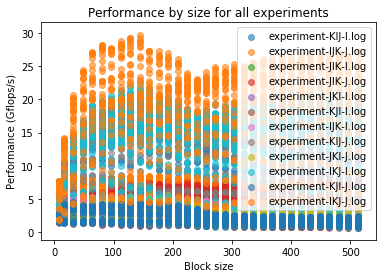

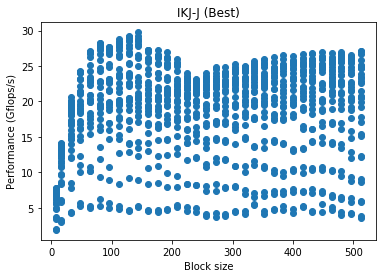

In [3]:
file_names=['experiment-'+perm+'-'+par+'.log' for perm in {'IJK', 'IKJ', 'JIK', 'JKI', 'KIJ', 'KJI'} for par in {'I', 'J'}]
file_results={}
for file_name in file_names:
    file_results[file_name]=plot_IJK.get_results_from_file(open(file_name, 'r'))
for f in file_results:
    file_results[f]=plot_IJK.avg_results(file_results[f])

for f in file_results:
    plot_results(plt, file_results[f], f, alpha=.6)
plt.xlabel('Block size')
plt.ylabel('Performance (Gflops/s)')
plt.title('Performance by size for all experiments')
plt.legend()
plt.show()

bestf='experiment-IKJ-J.log'
plot_results(plt, file_results[bestf], bestf)
plt.xlabel('Block size')
plt.ylabel('Performance (Gflops/s)')
plt.title('IKJ-J (Best)')
plt.show()

Thankfully, there's a clear winner. Let's take a closer look:

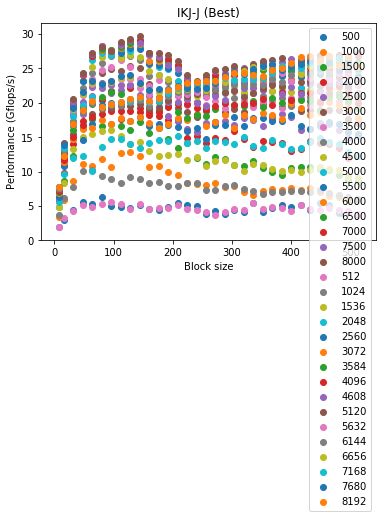

In [6]:
Ns=[N for N in range(500, 8001, 500)]+[N for N in range(512, 8193, 512)]
bresults=file_results[bestf]

r_Ns=[]

for N in Ns:
    r_N=[r for r in bresults if r.N==N]
    r_Ns.append(r_N)
    plot_results(plt, r_N, str(N))
plt.xlabel('Block size')
plt.ylabel('Performance (Gflops/s)')
plt.title('IKJ-J (Best)')
plt.legend()
plt.show()

It's kind of hard to see like this, but the ~500s are at the bottom, and the ~8000s are at the top. Let's look at a 3D plot to confirm the trend is increasing monotonically.

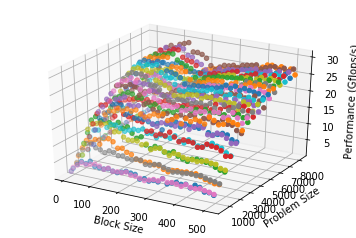

In [8]:
from mpl_toolkits.mplot3d import Axes3D
fig=plt.figure()
ax = fig.add_subplot(111, projection='3d')
for r_N in r_Ns:
    xs=[r.t1 for r in r_N]
    zs=[r.gflops_s() for r in r_N]
    ys=[r.N for r in r_N]
    ax.scatter(xs, ys, zs, label=str(N))
ax.set_xlabel('Block Size')
ax.set_ylabel('Problem Size')
ax.set_zlabel('Performance (Gflops/s)')
plt.show()

Indeed, there is an obvious and fairly straightforward correlation between problem size and performance.

Next up, we want to find the ideal block size for each N.

In [12]:
bestTs=[]
for r_N in r_Ns:
    r_N.sort(key=lambda x:x.gflops_s())
    bestTs.append((r_N[-1].N, r_N[-1].t1))

bestTs

[(500, 80),
 (1000, 128),
 (1500, 64),
 (2000, 128),
 (2500, 80),
 (3000, 128),
 (3500, 112),
 (4000, 96),
 (4500, 96),
 (5000, 144),
 (5500, 128),
 (6000, 144),
 (6500, 144),
 (7000, 144),
 (7500, 128),
 (8000, 144),
 (512, 96),
 (1024, 64),
 (1536, 96),
 (2048, 208),
 (2560, 112),
 (3072, 464),
 (3584, 96),
 (4096, 480),
 (4608, 480),
 (5120, 480),
 (5632, 448),
 (6144, 480),
 (6656, 480),
 (7168, 480),
 (7680, 432),
 (8192, 464)]

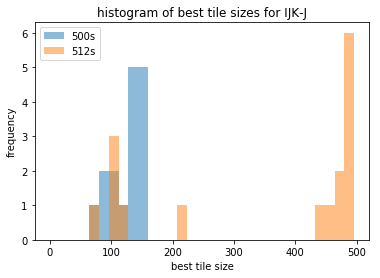

In [20]:
plt.hist([b[1] for b in bestTs if b[0]%500 == 0], label='500s', alpha=.5, bins=[x for x in range(0,501,16)])
plt.hist([b[1] for b in bestTs if b[0]%512 == 0], label='512s', alpha=.5, bins=[x for x in range(0,501,16)])
plt.legend()
plt.ylabel('frequency')
plt.xlabel('best tile size')
plt.title('histogram of best tile sizes for IJK-J')
plt.show()

We see that there is a bimodal distribution for the best tile sizes. All of the multiples of 500 are clustered in the 80-150 range, but multiples of 512 are split between that range and the upper end of our scale (with larger problem sizes preferring larger tiles).

If we're going to be padding our arrays to avoid exact power-of-two sizing, I would go for a tile size around 128, with an IKJ-J permutation.